In [1]:
####################
#
# A small notebook to analyze the results obtained
# in explianabilty_count called in Explainability_molly.ipynb
#
####################

In [ ]:
####################
#
# Initialization
#
####################

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from pathlib import Path
from drawinganalyses.datasets.drawings_pytorch import DrawingModule, DrawingDataset
from torch.utils.data import random_split
import torch

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
LOCAL_DATA_DIR = Path("/home/emaitre/MADE/molly-humains/")

In [4]:
annotations_file = "labels.csv" 
models_storage = LOCAL_DATA_DIR / "models"
dataset_name = 'Molly'
label_to_str = {0: 'Autumn', 1: 'Spring', 2: 'Summer', 3: 'Winter'}
batch_size=4
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize((256, 256))])

In [5]:
generator1 = torch.Generator().manual_seed(42)
dataset = DrawingDataset(
    dataset_name=dataset_name,
    annotations_file=annotations_file,
    data_dir=LOCAL_DATA_DIR,
    label_to_str=label_to_str,
    transform=transform)
trainset, valset, testset = random_split(dataset, [0.8, 0.1, 0.1], generator=generator1)

In [6]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                          shuffle=True, num_workers=2)

dataloaders={'train':trainloader, 'val':valloader, 'test':testloader}
dataset_sizes={'train':len(trainloader)*batch_size, 'val':len(valloader)*batch_size, 'test':len(testloader)*batch_size}


In [7]:
len(testloader)

129

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
class_names = list(label_to_str.values())

/home/emaitre/miniconda3/envs/MADE/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/emaitre/miniconda3/envs/MADE/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True

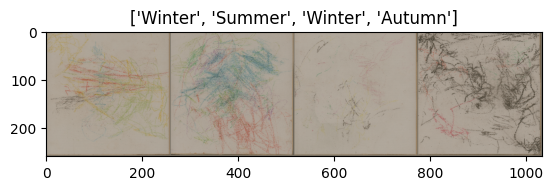

In [10]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(trainloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                label = label_to_str[labels[j].item()]
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}, real label : {label}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
PATH = './test_molly.pth'
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)
model_ft.load_state_dict(torch.load(LOCAL_DATA_DIR/PATH))
model_ft.eval()

/home/emaitre/miniconda3/envs/MADE/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/emaitre/miniconda3/envs/MADE/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/home/emaitre/miniconda3/envs/MADE/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/emaitre/miniconda3/envs/MADE/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True

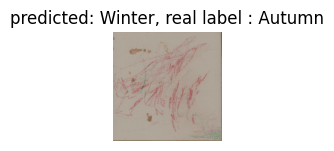

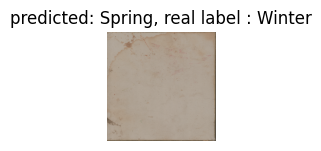

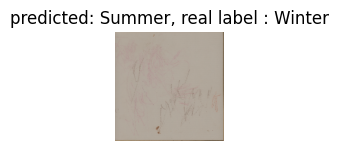

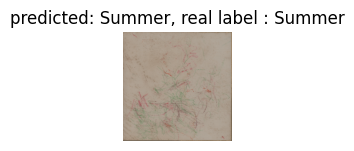

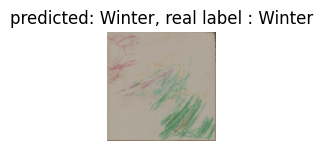

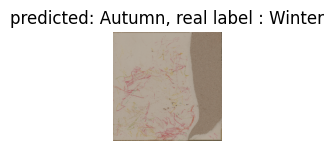

In [13]:
visualize_model(model_ft)

In [14]:
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
import torch.nn.functional as F

In [16]:
count_season = {'Autumn':[0,0], 'Spring':[0,0], 'Summer':[0,0], 'Winter':[0,0]}
index_store = {'Autumn': [[],[]], 'Spring':[[],[]], 'Summer':[[],[]], 'Winter':[[],[]]}

In [17]:
index_store

{'Autumn': [[], []],
 'Spring': [[], []],
 'Summer': [[], []],
 'Winter': [[], []]}

for idx, (inputs, labels) in enumerate(iter(testloader)):
    true_label = label_to_str[labels.item()]
    print(label_to_str[labels.item()])
    output = model_ft(inputs)
    print("output=", output)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()
    predicted_label = class_names[(pred_label_idx.item())]
    print("predicted_label=",predicted_label)
    print('Predicted:', predicted_label, '(', prediction_score .squeeze().item(), ')')

In [18]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=2)

In [19]:
inputs, labels = next(iter(trainloader))
true_label = label_to_str[labels.item()]
output = model_ft(inputs)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
predicted_label = class_names[(pred_label_idx.item())]

/home/emaitre/miniconda3/envs/MADE/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


/home/emaitre/miniconda3/envs/MADE/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
####################
#
# Captum
#
####################


inputs, labels = next(iter(trainloader))
true_label = label_to_str[labels.item()]
print(label_to_str[labels.item()])
output = model_ft(inputs)
print("output=", output)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
predicted_label = class_names[(pred_label_idx.item())]
print("predicted_label=",predicted_label)
print('Predicted:', predicted_label, '(', prediction_score .squeeze().item(), ')')

In [20]:
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

integrated_gradients = IntegratedGradients(model_ft)
attributions_ig = integrated_gradients.attribute(inputs, target=pred_label_idx, n_steps=200)

/home/emaitre/miniconda3/envs/MADE/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


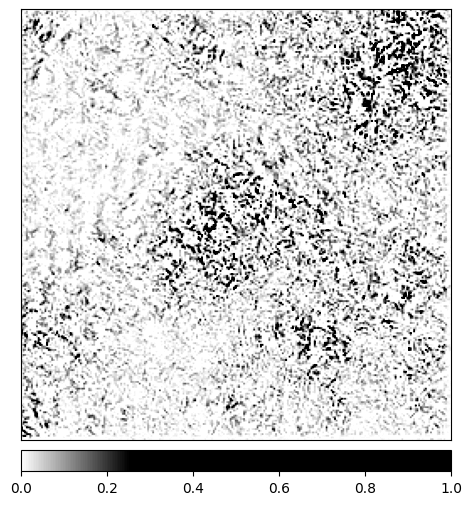

In [21]:
from matplotlib.colors import LinearSegmentedColormap

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(inputs.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

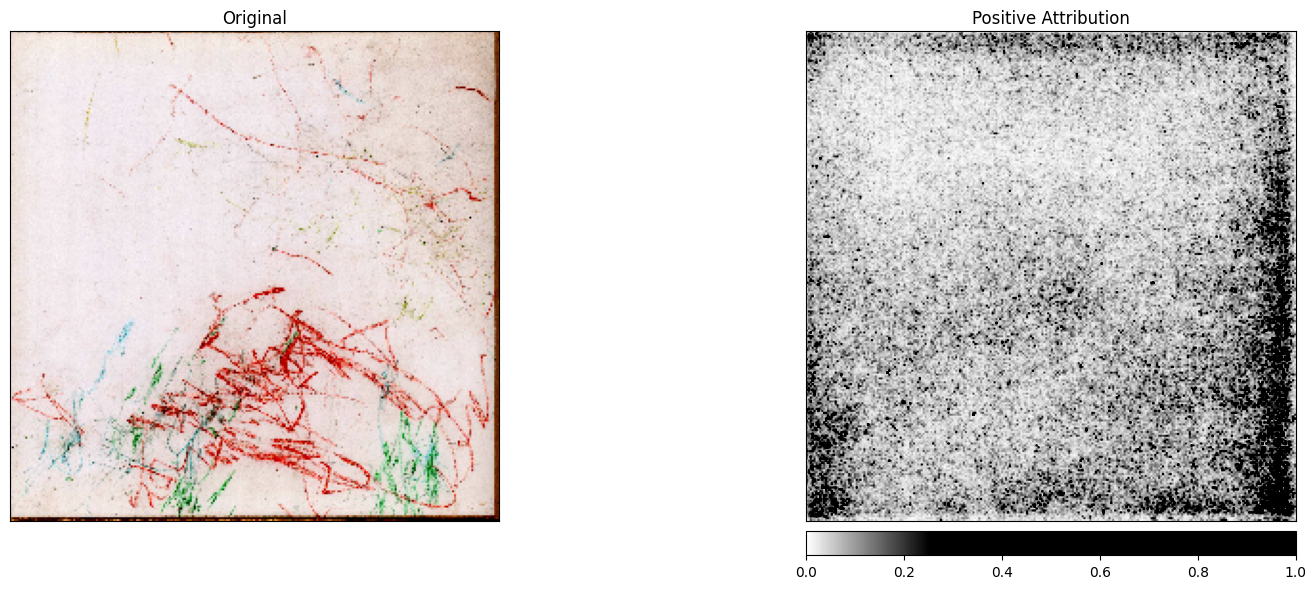

In [22]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(inputs, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(inputs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution"],
                                      fig_size=(18, 6))


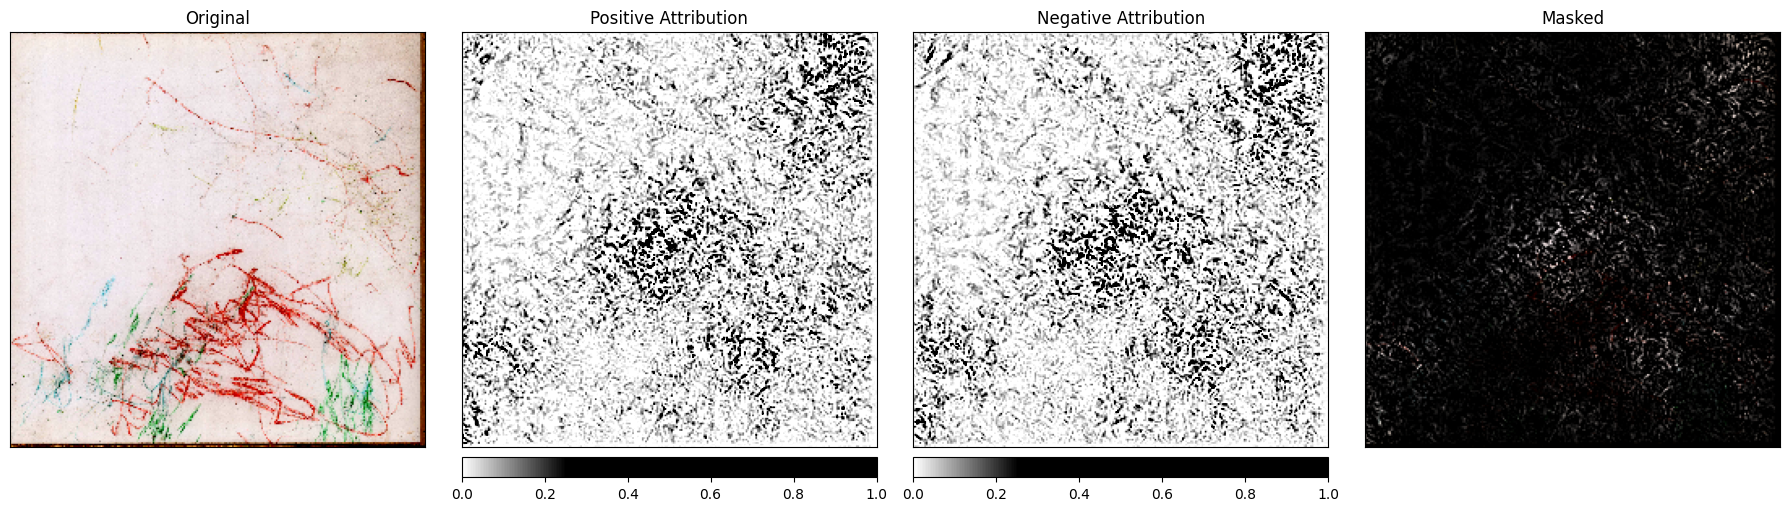

In [23]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model_ft)

# Defining baseline distribution of images
rand_img_dist = torch.cat([inputs * 0, inputs * 1])

attributions_gs = gradient_shap.attribute(inputs,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(inputs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map", "heat_map", "masked_image"],
                                      ["all", "positive", "negative", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
                                      fig_size=(18, 6))


In [24]:
occlusion = Occlusion(model_ft)

attributions_occ = occlusion.attribute(inputs,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)


/home/emaitre/miniconda3/envs/MADE/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/emaitre/miniconda3/envs/MADE/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True

KeyboardInterrupt: 

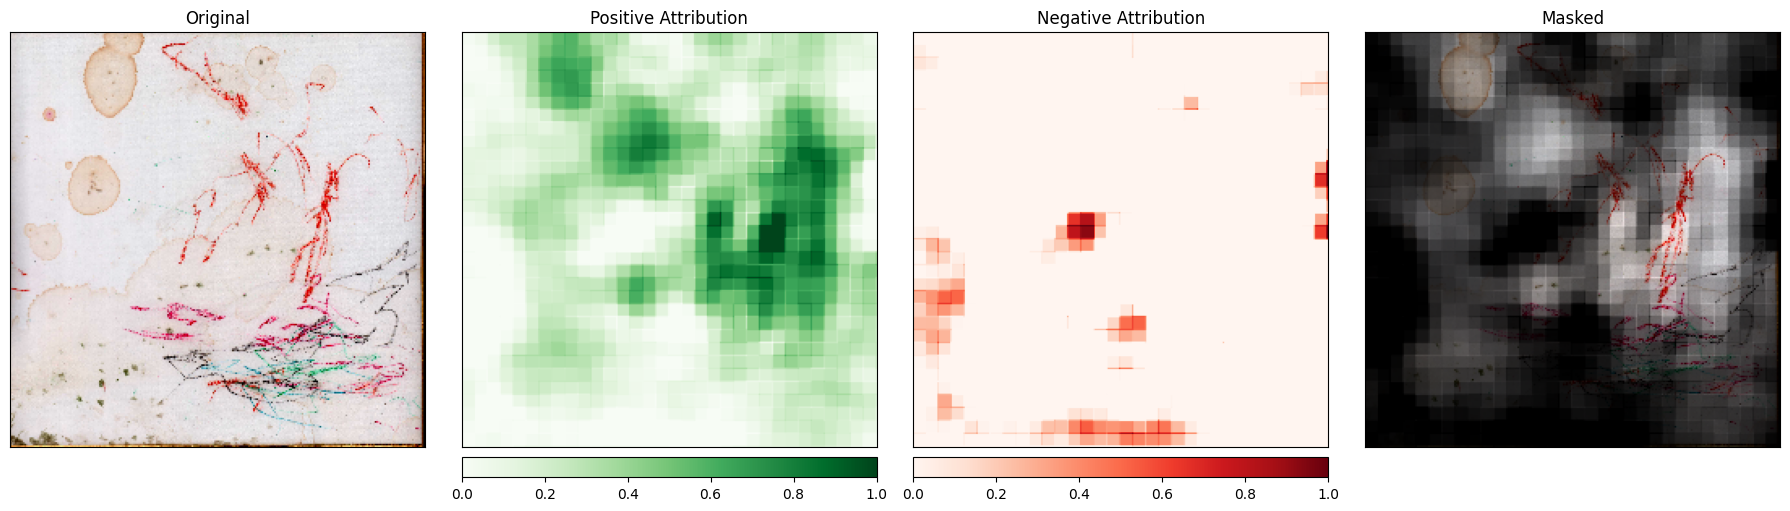

In [ ]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(inputs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map", "heat_map", "masked_image"],
                                      ["all", "positive", "negative", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
                                      fig_size=(18, 6)
                                     )


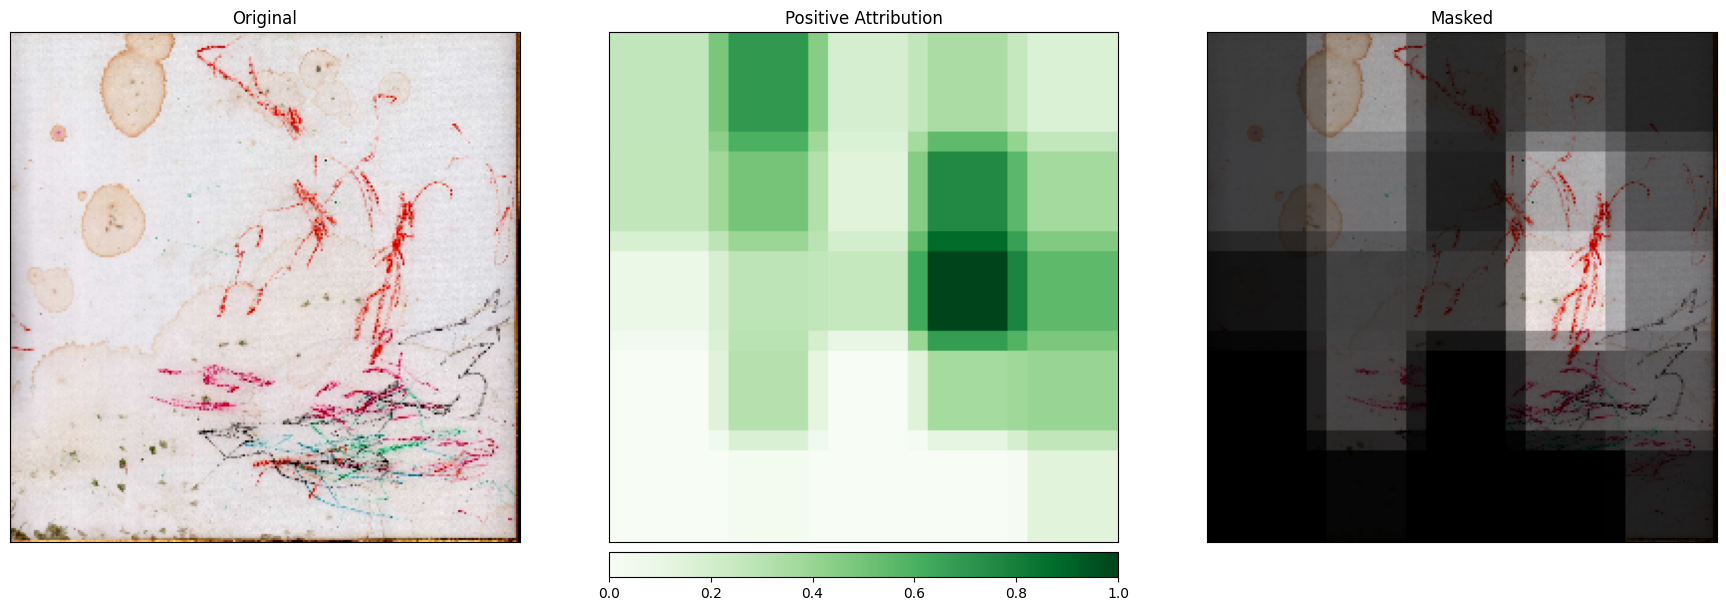

In [ ]:
occlusion = Occlusion(model_ft)

attributions_occ = occlusion.attribute(inputs,
                                       strides = (3, 50, 50),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(inputs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map", "masked_image"],
                                      ["all", "positive", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      titles=["Original", "Positive Attribution", "Masked"],
                                      fig_size=(18, 6)
                                     )


In [ ]:
####################
#
# Run applied to multiple images
#
####################

In [ ]:
from drawinganalyses.utils.visualization import explinability_images

In [ ]:
from drawinganalyses.utils.statistics import explinability_count

t = 0

explinability_count(trainloader, model_ft, label_to_str, class_names, t)

In [ ]:
count_season = {'Autumn':[0,0], 'Spring':[0,0], 'Summer':[0,0], 'Winter':[0,0]}


In [ ]:
explinability_images(trainloader, model_ft, label_to_str, class_names, count_season)

/home/emaitre/miniconda3/envs/MADE/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/emaitre/miniconda3/envs/MADE/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True

Predicted: Summer ( 0.5126268267631531 )
Ground truth: Autumn
total count : 0


KeyboardInterrupt: 